# Trabalho 2 IART: Aprendizagem Supervisionada - Regressão
## Introdução
O futebol é possivelmente o desporto mais popular de sempre com milhões de adeptos e um igual número de jogadores dado ser talvez um dos desportos mais fáceis de jogar que existe.

Para além disso, este desporto movimenta uma grande quantidade de dinheiro quer pela venda de bilhetes e _merchandise_ quer pelas transferências de jogadores. Outro lado desta economia é o mercado das apostas desportivas que é cada vez mais procurado por adeptos. Sabe-se que os apostadores profissionais acertam na sua aposta cerca de 53% das vezes.

Sendo assim, o objetivo deste trabalho é prever o resultado de jogos de maneira a criar um sistema que recomenda o resultado do jogo em que apostar, preferivelmente com uma precisão superior à dos apostadores profissionais.

## Descrição do _dataset_
O _dataset_ inclui informação acerca de 25000 partidas de futebol em ligas de 11 países europeus realizadas nas épocas de 2008 a 2016 e acerca de 10000 jogadores. Este inclui ainda informação sobre os _odds_ fornecidos por vários _sites_ de apostas para os vários jogos.
Mais informação pode ser encontrada [aqui](https://www.kaggle.com/hugomathien/soccer).

## Aquisição e exploração de dados
O _dataset_ que irá ser usado corresponde a uma base de dados sqlite que inclui as tabelas a seguir apresentadas e que contêm a seguinte informação:

In [ ]:
import sqlite3

conn = sqlite3.connect('soccer.db')
cursor = conn.cursor()
cursor.execute("select name from sqlite_master where type='table'; ")
cursor.fetchall()

* **Country:**  Países para os quais existe informação.
* **League:** Ligas de futebol dos vários países incluídos na tabela _Country_.
* **Match:** Informação sobre as várias partidas de futebol que inclui estatísticas do jogo, _odds_, bem como os jogadores que participaram.
* **Player:** Informação sobre os vários jogadores da base de dados, incluindo nome, data de nascimento, altura e peso.
* **Player_Attributes:** Habilidades de cada um dos jogadores tiradas do jogo FIFA.
* **Team:** Informação acerca de cada uma das equipas, incluindo o seu nome.
* **Team_Attributes:** Habilidades de cada uma das equipas tiradas do jogo FIFA.

Dado tratar-se de um _dataset_ extenso (~300MB) apenas serão consideradas partidas jogadas na English Premier League, já que corresponde a uma liga com um número razoável de equipas e jogos. Sendo assim, os passos seguintes têm como objetivo extrair informação acerca desta liga.

In [11]:
import pandas as pd

matches = pd.read_sql_query("select League.name, Match.season, T1.team_long_name as home_team, Match.home_team_goal, T2.team_long_name as away_team, away_team_goal, stage, date, B365H, B365D, B365A from League, Match on (League.id = Match.league_id), Team as T1 on (T1.team_api_id = Match.home_team_api_id), Team as T2 on (T2.team_api_id = Match.away_team_api_id) where League.name = 'England Premier League'", conn)
matches.head()

,name,season,home_team,home_team_goal,away_team,away_team_goal,stage,date,B365H,B365D,B365A
0,England Premier League,2008/2009,Manchester United,1,Newcastle United,1,1,2008-08-17 00:00:00,1.29,5.5,11.00
1,England Premier League,2008/2009,Arsenal,1,West Bromwich Albion,0,1,2008-08-16 00:00:00,1.20,6.5,15.00
2,England Premier League,2008/2009,Sunderland,0,Liverpool,1,1,2008-08-16 00:00:00,5.50,3.6,1.67
3,England Premier League,2008/2009,West Ham United,2,Wigan Athletic,1,1,2008-08-16 00:00:00,1.91,3.4,4.20
4,England Premier League,2008/2009,Aston Villa,4,Manchester City,2,1,2008-08-17 00:00:00,1.91,3.4,4.33


Vamos agora criar três novas colunas que representam para cada jogo o lado vencedor (equipa da casa ou equipa de fora) ou empate.

In [12]:
matches = matches.assign(home_win=lambda matches: matches.apply(lambda row: 1 if row.home_team_goal > row.away_team_goal else 0, axis='columns'),
              draw=lambda matches: matches.apply(lambda row: 1 if row.home_team_goal == row.away_team_goal else 0, axis='columns'),
              away_win=lambda matches: matches.apply(lambda row: 1 if row.home_team_goal < row.away_team_goal else 0, axis='columns'))

Podemos agora calcular a taxa de vitórias, empates e derrotas em relação à equipa que joga em casa.

In [13]:
win_rates = matches.groupby('season') \
                   .mean() \
                   .loc[:, ['home_win', 'draw', 'away_win']]
win_rates

,home_win,draw,away_win
season,,,
2008/2009,0.455263,0.255263,0.289474
2009/2010,0.507895,0.252632,0.239474
2010/2011,0.471053,0.292105,0.236842
2011/2012,0.450000,0.244737,0.305263
2012/2013,0.436842,0.284211,0.278947
2013/2014,0.471053,0.205263,0.323684
2014/2015,0.452632,0.244737,0.302632
2015/2016,0.413158,0.281579,0.305263


Com estes dados podemos concluir que as equipas que jogam em casa têm uma maior possibilidade de vencer a partida.
Cerca de 46% dos jogos acabam com a vitória da equipa da casa, 28% acabam com vitória da equipa de fora e o acontecimento menos comum é o empate que ocorre em 26% dos jogos. Apresenta-se agora um gráfico com a evolução das taxas em estudo:

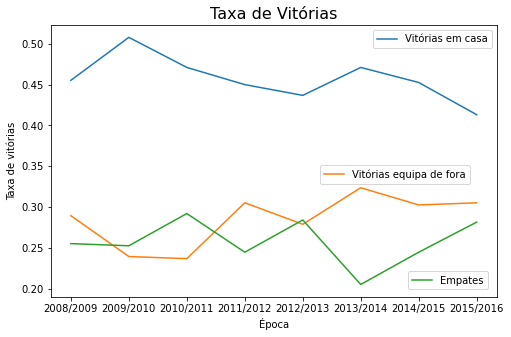

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)


home_line = ax.plot(win_rates.home_win, label='Vitórias em casa')
away_line = ax.plot(win_rates.away_win, label='Vitórias equipa de fora')
draw_line = ax.plot(win_rates.draw, label='Empates')
ax.set_xlabel("Época")
ax.set_ylabel("Taxa de vitórias")
plt.title("Taxa de Vitórias", fontsize=16)

# Add the legend locations
home_legend = plt.legend(handles=home_line, loc='upper right', bbox_to_anchor=(1, 1))
ax = plt.gca().add_artist(home_legend)
away_legend = plt.legend(handles=away_line, loc='center right', bbox_to_anchor=(0.95, 0.45))
ax = plt.gca().add_artist(away_legend)
draw_legend = plt.legend(handles=draw_line, loc='center right', bbox_to_anchor=(0.99, 0.06))

Podemos observar no gráfico que cada vez é mais difícil ter uma vitória em casa, parecendo ser cada vez mais provável haver um empate.

Uma medida interessante é quão vantajoso é para uma equipa, jogar em casa (HGA ou *Home Ground Advantage*) definido como a diferença entre a probabilidade da equipa ganhar em casa e a de ganhar fora.

In [14]:
home_win_rates = matches.groupby(['home_team']) \
                   .home_win \
                   .mean()

away_win_rates = matches.groupby(['away_team']) \
                   .away_win \
                   .mean()

hga = (home_win_rates - away_win_rates).reset_index().rename(columns={0: 'HGA'}).sort_values(by='HGA', ascending=False)
hga.head()

,home_team,HGA
16,Manchester City,0.335526
12,Fulham,0.289474
17,Manchester United,0.263158
25,Stoke City,0.263158
21,Portsmouth,0.236842


Mais interessante ainda é a variação desta medida ao longo do tempo para os vários clubes.

In [17]:
big_clubs = ['Liverpool', 'Manchester City', 'Manchester United', 'Chelsea', 'Arsenal']
home_win_rates_5 = matches[matches.home_team.isin(big_clubs)].groupby(['home_team', 'season']).home_win.mean()
away_win_rates_5 = matches[matches.away_team.isin(big_clubs)].groupby(['away_team', 'season']).away_win.mean()

hga_top_5 = home_win_rates_5 - away_win_rates_5

hga_top_5.unstack(level=0)

home_team,Arsenal,Chelsea,Liverpool,Manchester City,Manchester United
season,,,,,
2008/2009,0.105263,-0.157895,-0.052632,0.578947,0.210526
2009/2010,0.368421,0.368421,0.421053,0.315789,0.263158
2010/2011,0.157895,0.368421,0.368421,0.263158,0.684211
2011/2012,0.157895,0.315789,-0.105263,0.421053,0.105263
2012/2013,0.052632,0.105263,0.105263,0.263158,0.210526
2013/2014,0.105263,0.263158,0.315789,0.368421,-0.052632
2014/2015,0.105263,0.210526,0.105263,0.210526,0.421053
2015/2016,0.210526,-0.105263,0.000000,0.263158,0.263158


Apresenta-se a seguir um gráfico que representa a tabela acima.

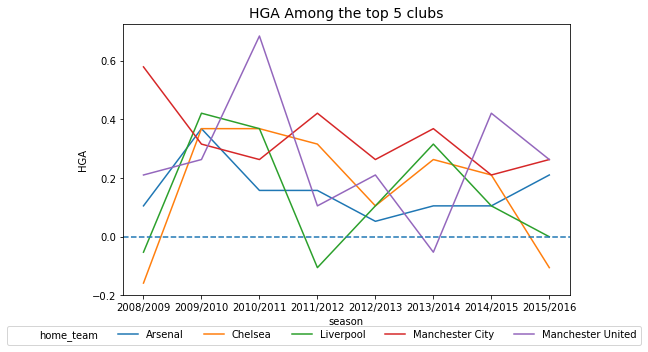

In [38]:
import seaborn as sns

plt.figure(figsize=(8, 5))
plot = sns.lineplot(x='season', y='HGA', hue='home_team', data=hga_top_5.reset_index().rename(columns={0: 'HGA', 'home_team': 'home_team'}))
plt.legend(loc='lower center', ncol=6, bbox_to_anchor=(0.45, -0.2))
plt.title("HGA Among the top 5 clubs", fontsize=14)

plot.axes.axhline(0, ls='--')

plt.show()

Os resultados são erráticos mas há duas equipas que têm esta medida sempre positiva (Arsenal e Manchester City). Interessantemente, algumas equipas, em algumas épocas ganharam mais jogos fora de casa do que em casa.

## Preparação dos Dados